YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing BTC-USD:

Performance Metrics:
Total Return: 3.2878
Annual Volatility: 0.4030
Sharpe Ratio: 2.6966
Max Drawdown: -0.2296
MSE vs Buy&Hold: 1882237.5880

Processing ETH-USD:

Performance Metrics:
Total Return: 5.4548
Annual Volatility: 0.5688
Sharpe Ratio: 2.5508
Max Drawdown: -0.3017
MSE vs Buy&Hold: 23582755.0118


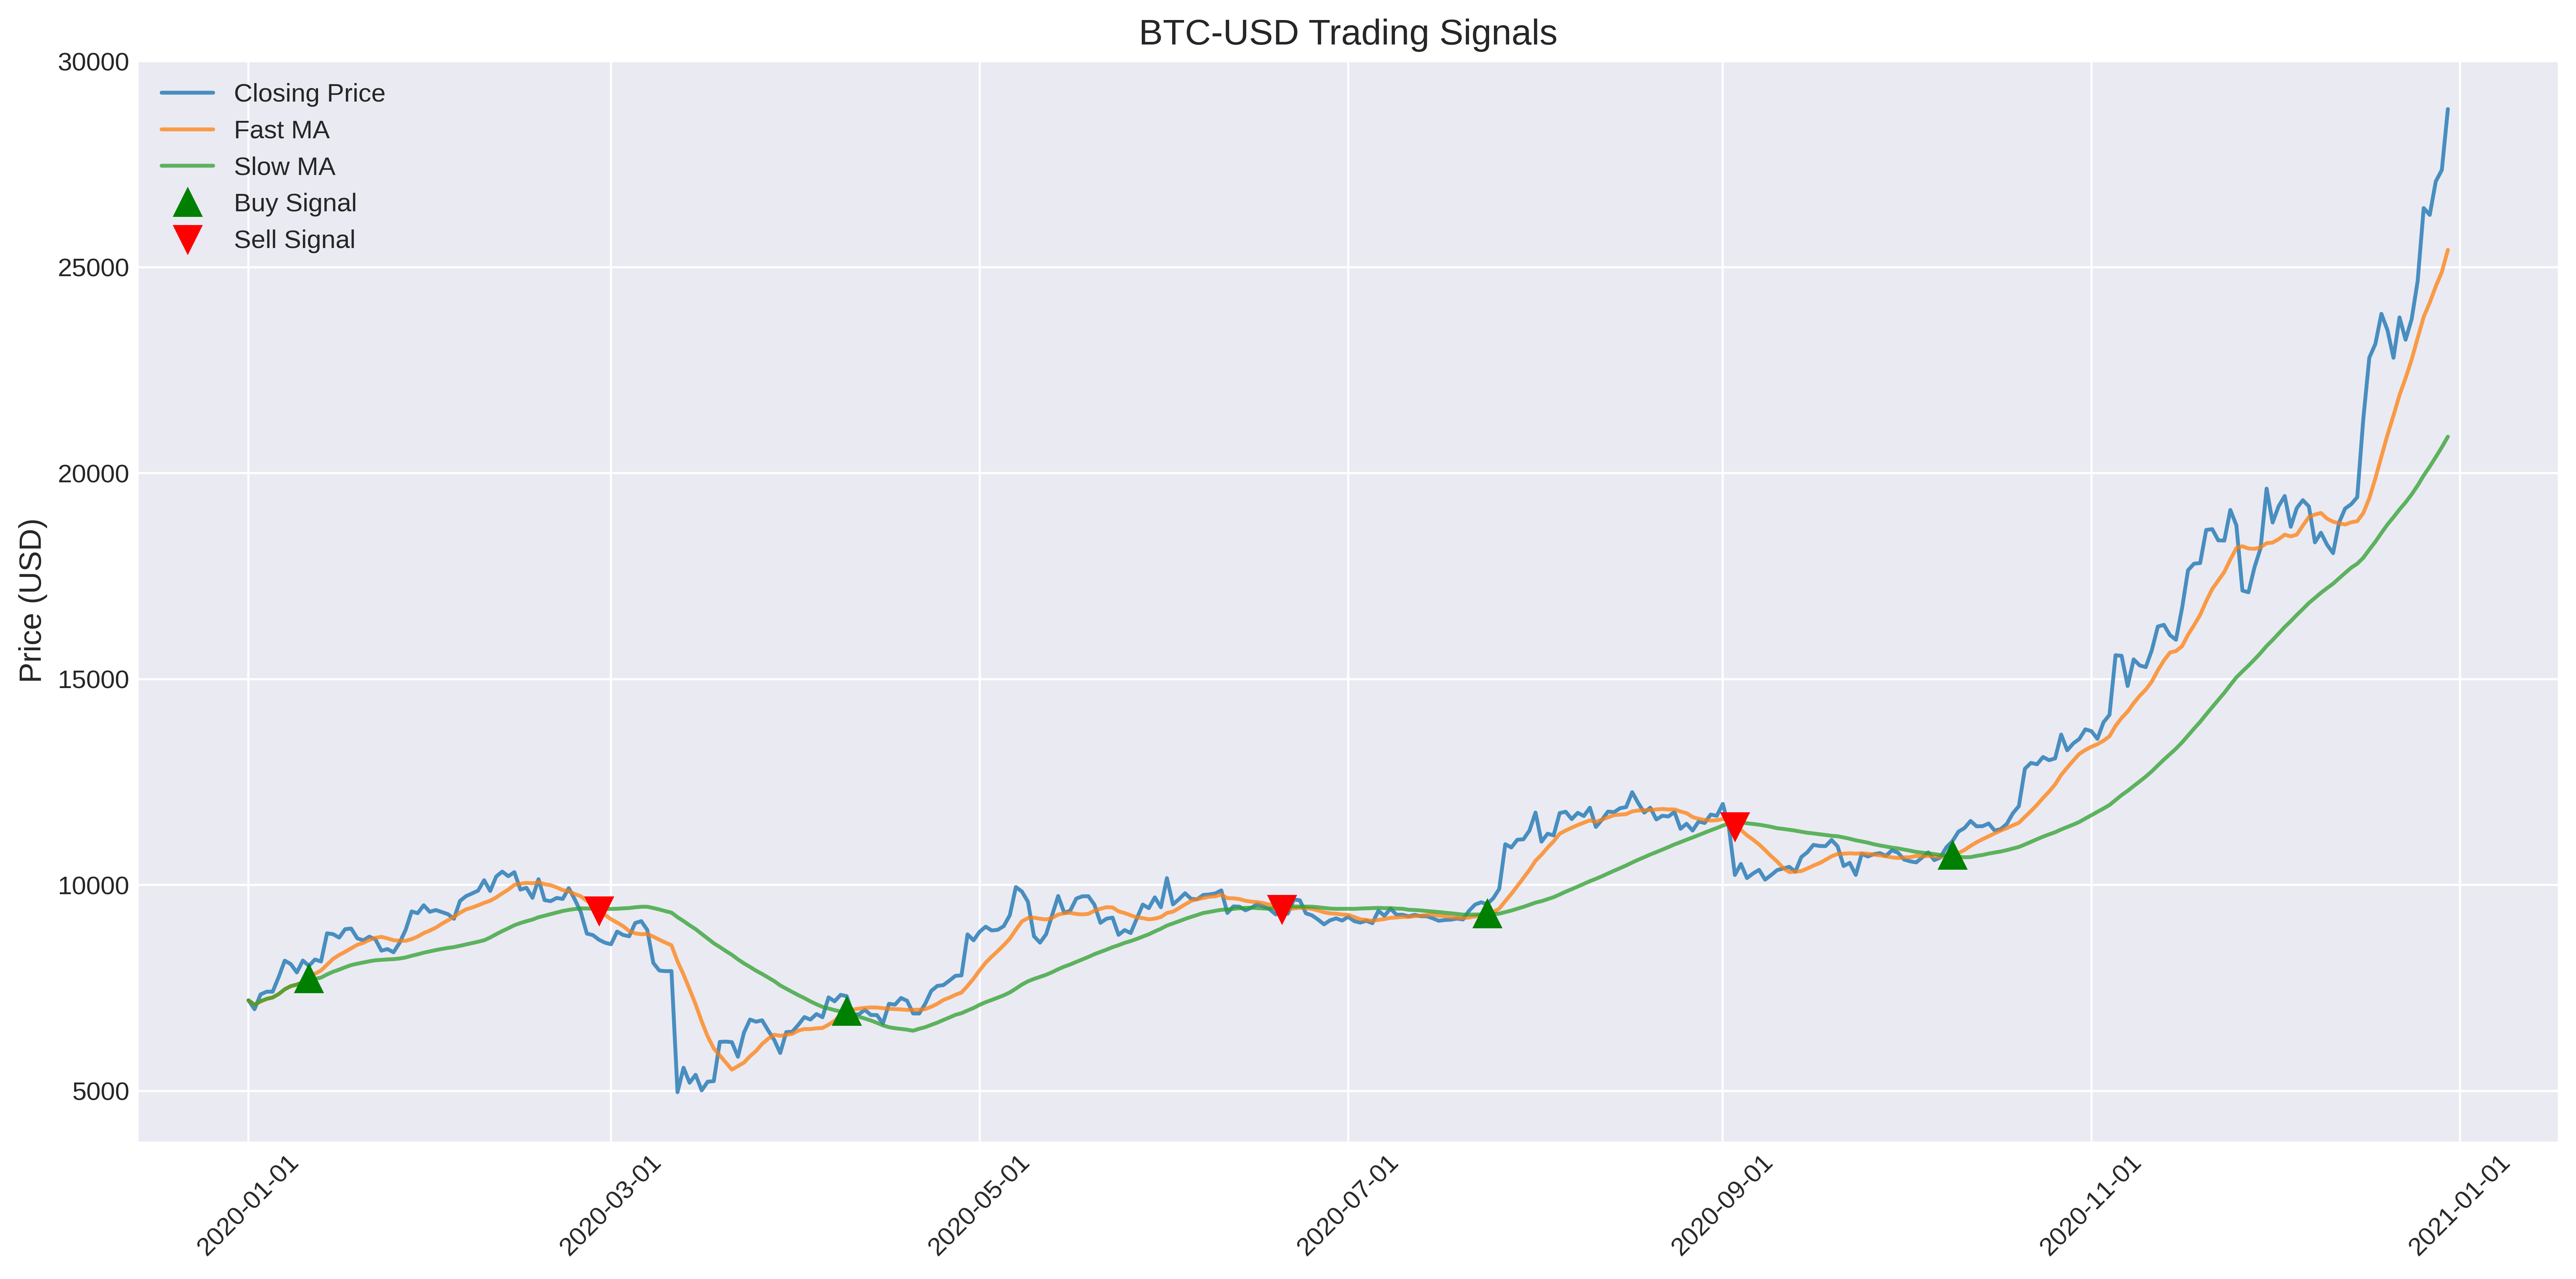

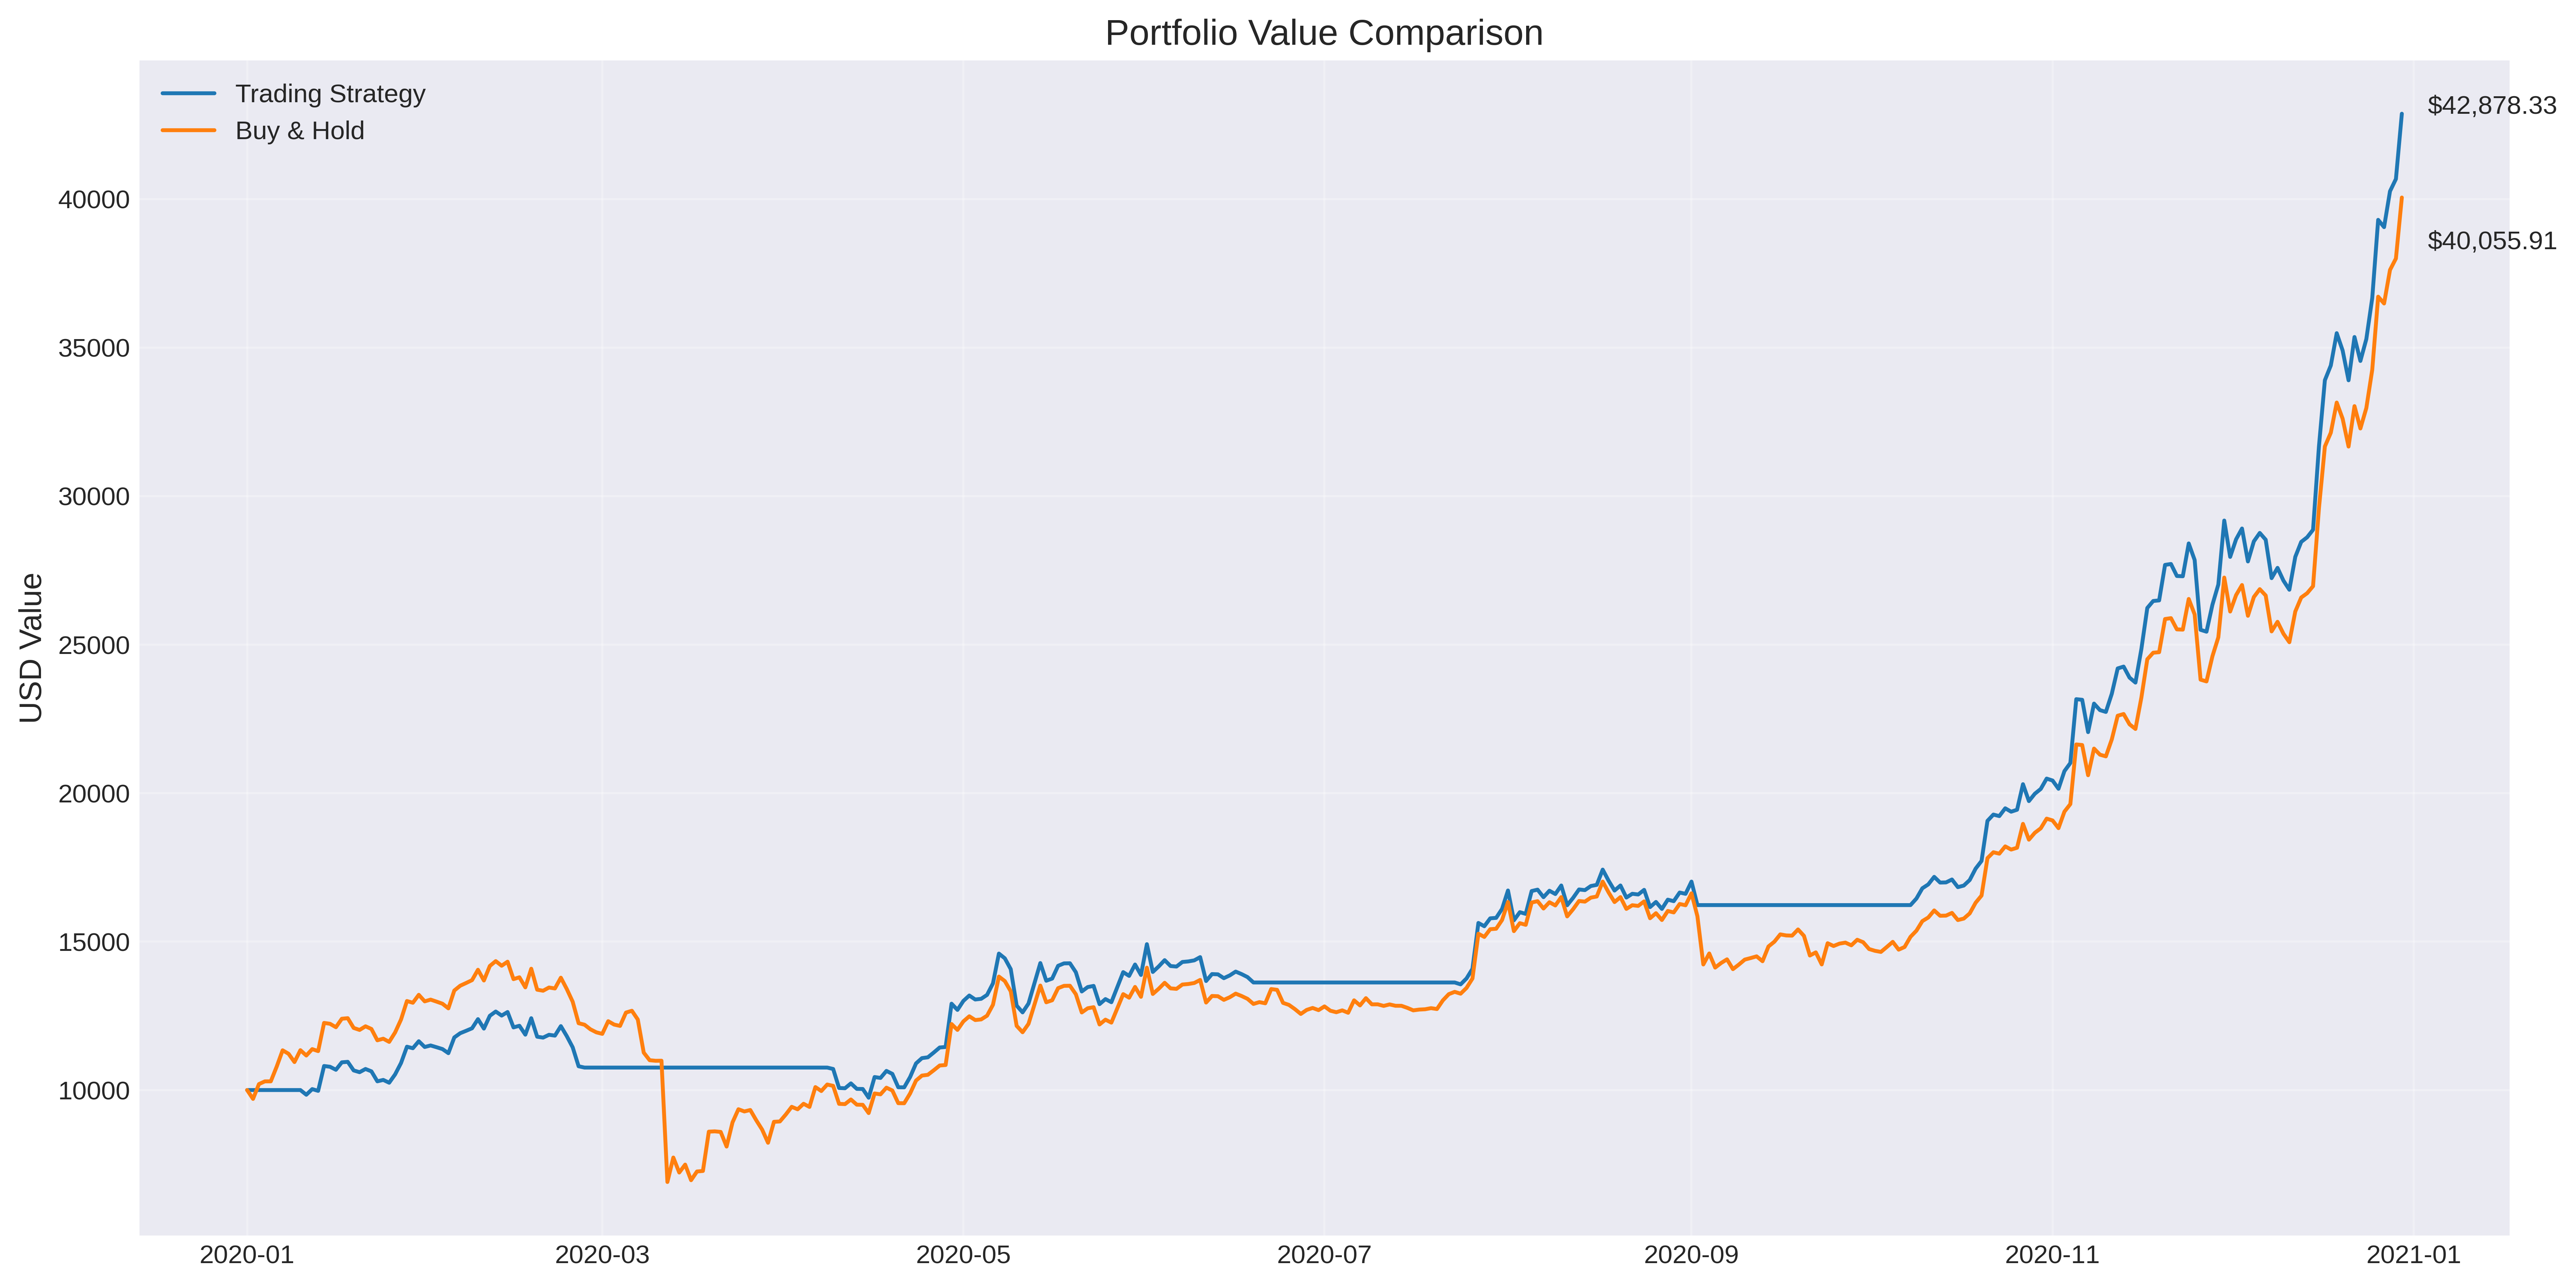

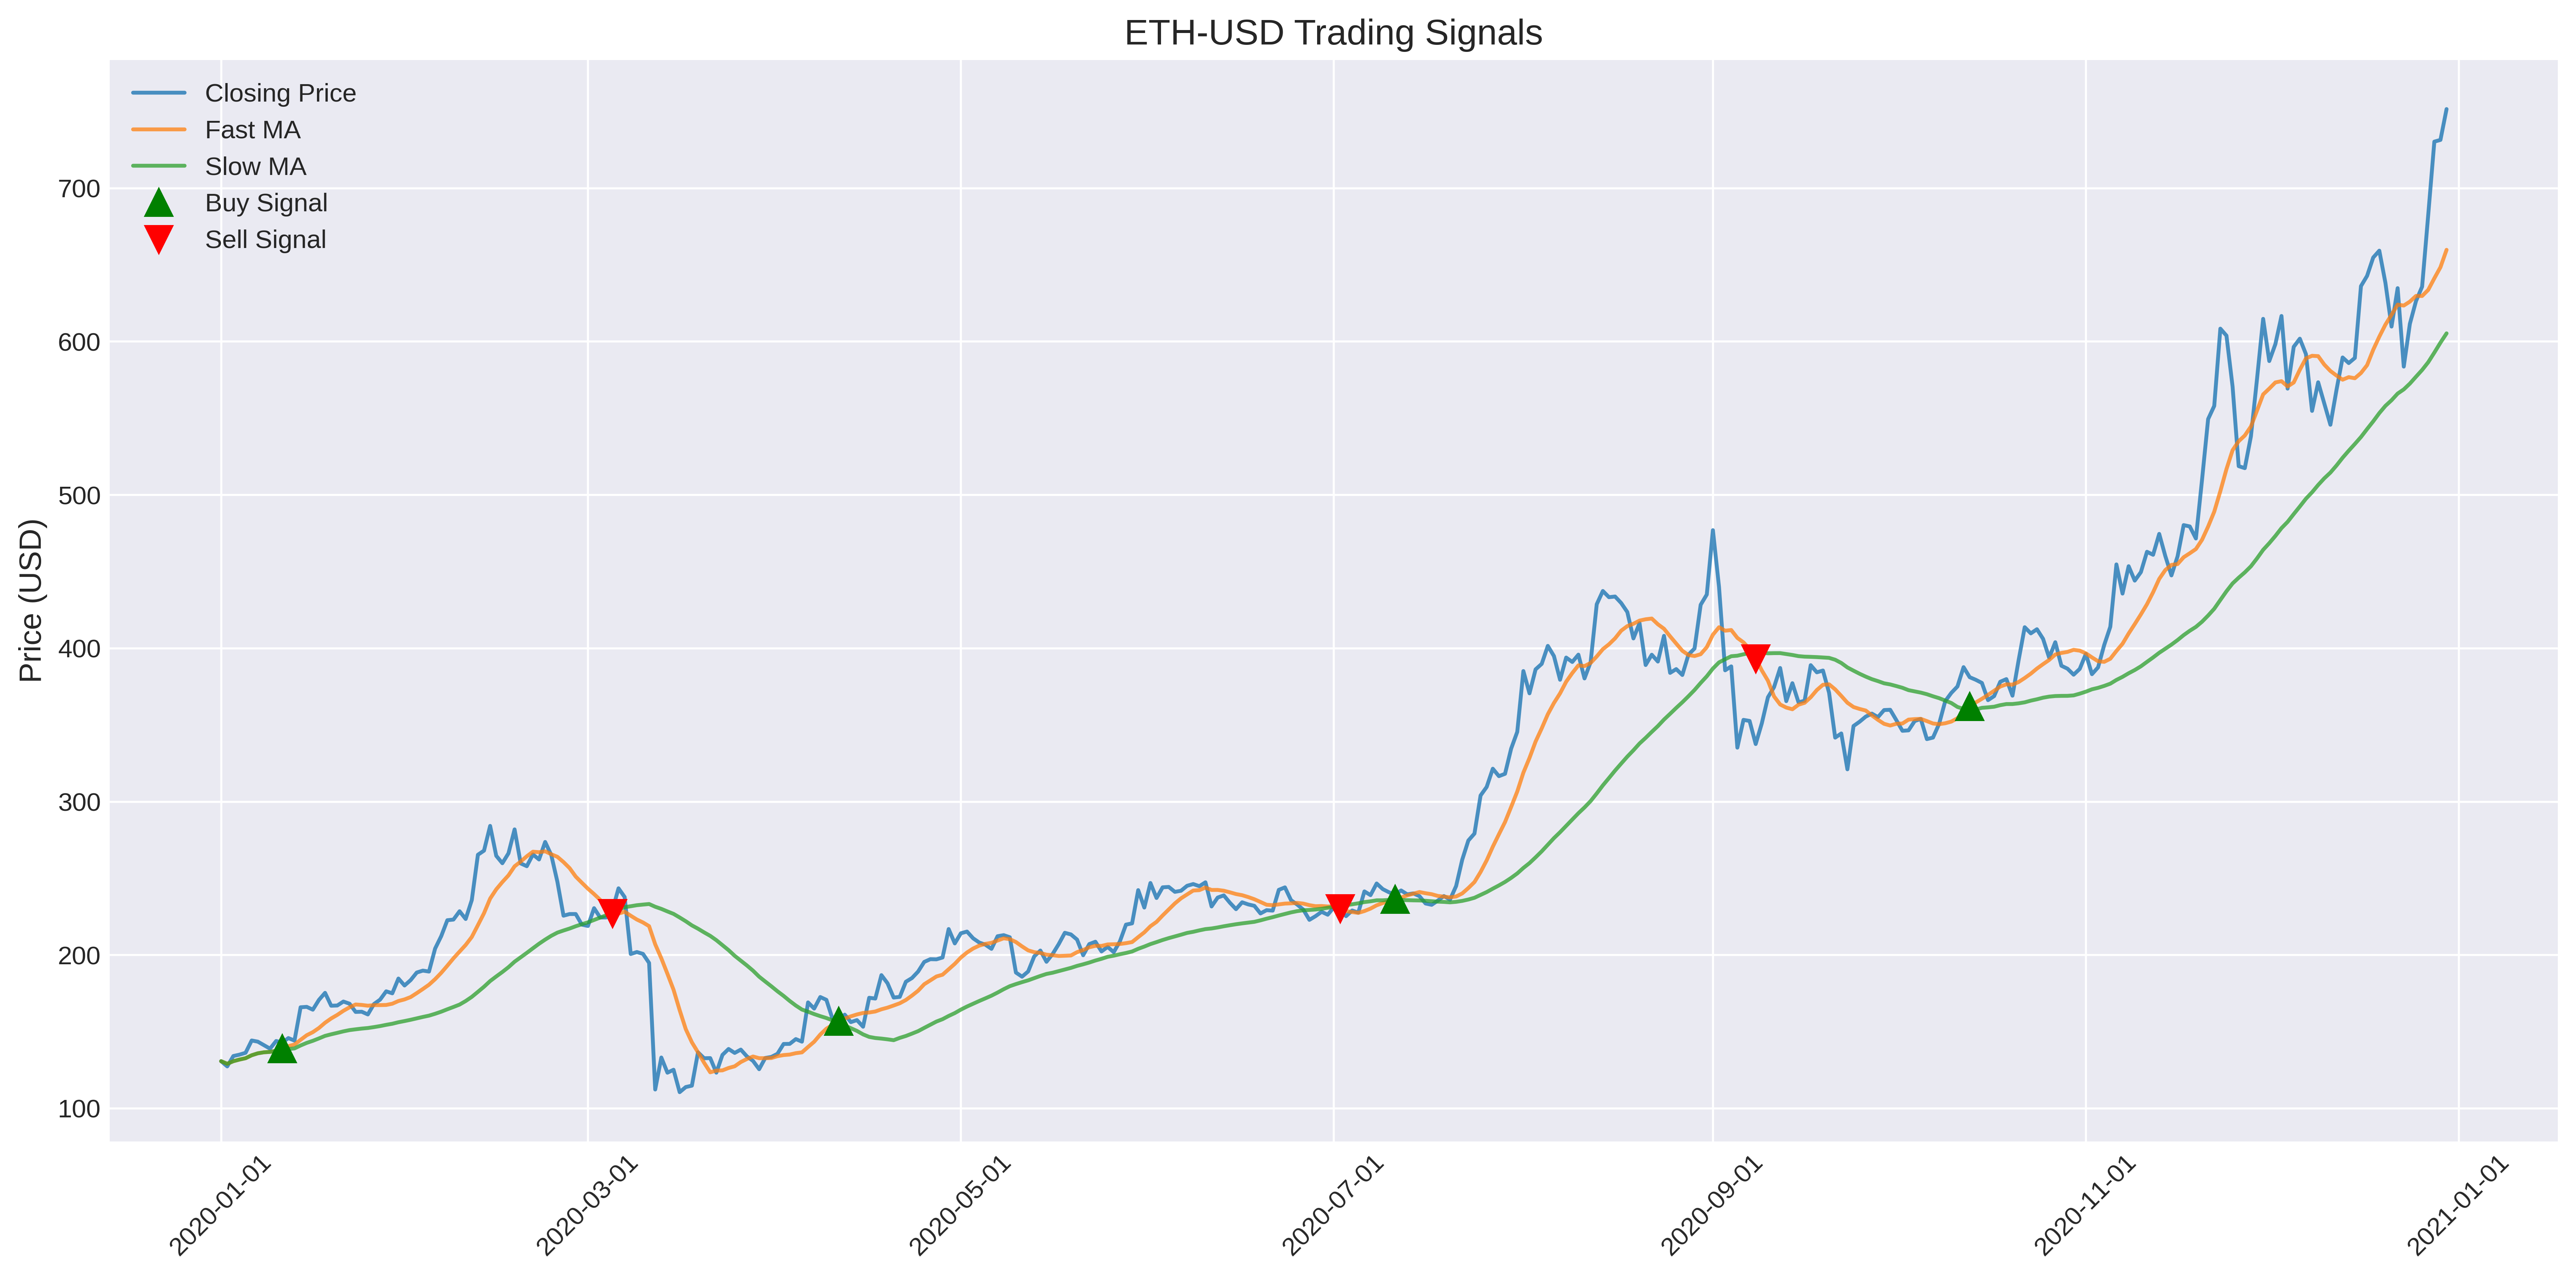

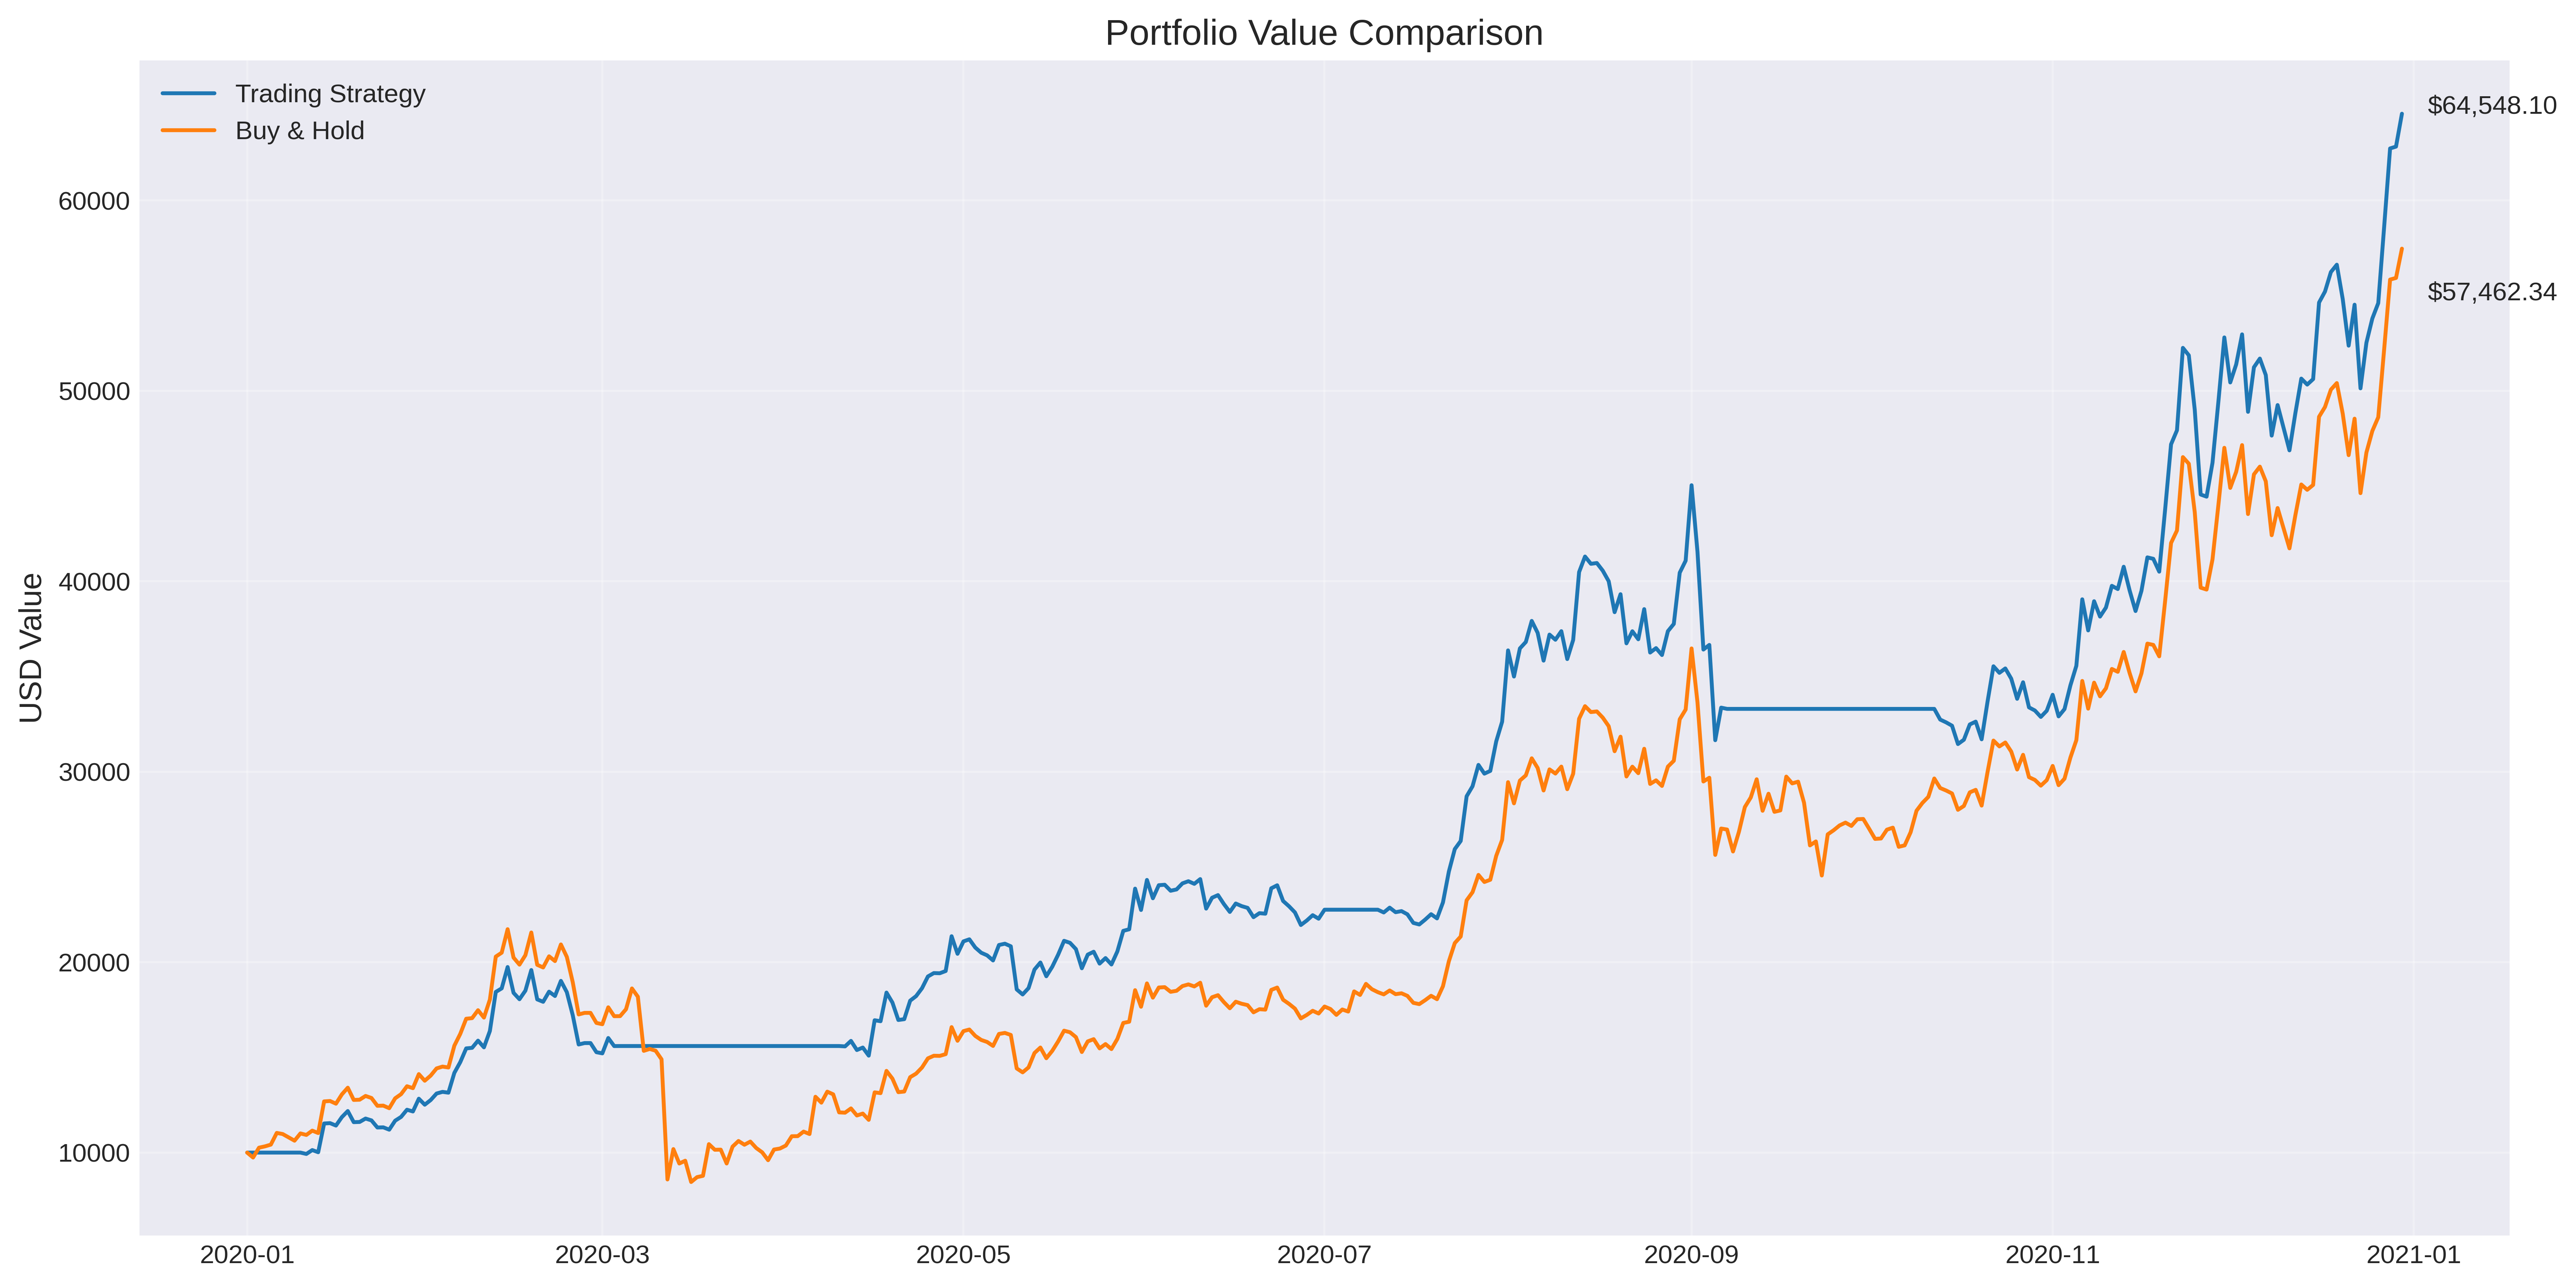

In [1]:
"""
Trading algorithm with multi-asset support and advanced analytics
"""

# Core Financial Modules
import yfinance as market_data
import pandas as pd
import numpy as np
from datetime import timedelta

# Visualization Enhancements
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Performance Metrics
from sklearn.metrics import mean_squared_error


# DATA ACQUISITION MODULE
class CryptoDataFetcher:
    def __init__(self, assets, start_date, end_date):
        self.tickers = assets
        self.start = start_date
        self.end = end_date
        self.datasets = {}

    def fetch_market_data(self, interval='1d'):
        """Retrieve multi-asset historical data"""
        for symbol in self.tickers:
            self.datasets[symbol] = market_data.download(
                symbol,
                start=self.start,
                end=self.end,
                interval=interval
            ).dropna()
        return self.datasets


# TECHNICAL ANALYSIS ENGINE
class TradingSignalsGenerator:
    def __init__(self, price_data):
        self.data = price_data.copy()
        self.signals = pd.DataFrame(index=self.data.index)

    def compute_moving_averages(self, short_window=10, long_window=40):
        """Calculate dual moving averages"""
        self.data['Fast_MA'] = self.data['Close'].rolling(window=short_window, min_periods=1).mean()
        self.data['Slow_MA'] = self.data['Close'].rolling(window=long_window, min_periods=1).mean()
        return self.data

    def generate_trading_signals(self):
        """Create position-based trading signals"""
        self.signals['Position'] = np.where(self.data['Fast_MA'] > self.data['Slow_MA'], 1.0, 0.0)
        self.signals['Entry'] = self.signals['Position'].diff()
        return self.signals


# BACKTESTING FRAMEWORK
class PortfolioSimulator:
    def __init__(self, initial_capital=10000.0):
        self.initial_balance = initial_capital

    def simulate_strategy(self, price_data, signals):
        """Run trading strategy simulation"""
        portfolio = pd.DataFrame(index=signals.index)
        # Corrected line: call pct_change() first, then call fillna(0) on the result
        portfolio['Asset_Returns'] = price_data['Close'].pct_change().fillna(0)
        portfolio['Strategy_Returns'] = np.where(signals['Position'] == 1, portfolio['Asset_Returns'], 0)
        portfolio['Strategy_Value'] = (self.initial_balance * (1 + portfolio['Strategy_Returns']).cumprod())
        portfolio['Buy_Hold_Value'] = (self.initial_balance * (1 + portfolio['Asset_Returns']).cumprod())
        return portfolio

# VISUALIZATION MODULE
class TradingVisualizer:
    @staticmethod
    def plot_price_signals(asset_data, signals, symbol):
        """Visualize price action with trading signals"""
        fig, ax = plt.subplots(figsize=(14, 7), dpi=500)

        # Price and indicators
        ax.plot(asset_data['Close'], label='Closing Price', alpha=0.8)
        ax.plot(asset_data['Fast_MA'], label='Fast MA', alpha=0.75)
        ax.plot(asset_data['Slow_MA'], label='Slow MA', alpha=0.75)

        # Signal markers
        buy_signals = signals.loc[signals['Entry'] == 1.0]
        sell_signals = signals.loc[signals['Entry'] == -1.0]

        ax.plot(buy_signals.index, asset_data.loc[buy_signals.index, 'Fast_MA'], '^', markersize=10, color='g', label='Buy Signal')
        ax.plot(sell_signals.index, asset_data.loc[sell_signals.index, 'Fast_MA'],'v', markersize=10, color='r', label='Sell Signal')

        # Formatting
        ax.set_title(f'{symbol} Trading Signals', fontsize=14)
        ax.set_ylabel('Price (USD)', fontsize=12)
        ax.legend(loc='best')
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        return fig

    @staticmethod
    def plot_performance_comparison(portfolio):
        """Compare strategy vs buy-and-hold"""
        fig, ax = plt.subplots(figsize=(14, 7), dpi=500)

        ax.plot(portfolio['Strategy_Value'], label='Trading Strategy')
        ax.plot(portfolio['Buy_Hold_Value'], label='Buy & Hold')

        # Annotate final values
        final_strategy = portfolio['Strategy_Value'].iloc[-1]
        final_buyhold = portfolio['Buy_Hold_Value'].iloc[-1]

        ax.annotate(f'${final_strategy:,.2f}', xy=(portfolio.index[-1], final_strategy), xytext=(10, 0), textcoords='offset points')
        ax.annotate(f'${final_buyhold:,.2f}', xy=(portfolio.index[-1], final_buyhold), xytext=(10, -20), textcoords='offset points')

        # Formatting
        ax.set_title('Portfolio Value Comparison', fontsize=14)
        ax.set_ylabel('USD Value', fontsize=12)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        return fig

# PERFORMANCE ANALYTICS
def calculate_performance_metrics(portfolio):
    """Compute key performance indicators"""
    returns = portfolio['Strategy_Returns']
    total_return = (portfolio['Strategy_Value'].iloc[-1] / portfolio['Strategy_Value'].iloc[0]) - 1

    # Risk metrics
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)


    # Drawdown calculation
    peak = portfolio['Strategy_Value'].cummax()
    drawdown = (portfolio['Strategy_Value'] - peak) / peak
    max_drawdown = drawdown.min()


    metrics = {
        'Total Return': total_return,
        'Annual Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'MSE vs Buy&Hold': mean_squared_error(
            portfolio['Strategy_Value'],
            portfolio['Buy_Hold_Value']
        )
    }
    return metrics


# EXECUTION PIPELINE
if __name__ == "__main__":
    # Configuration
    ASSETS = ['BTC-USD', 'ETH-USD']  # Multi-asset support
    START = '2020-01-01'
    END = '2020-12-31'
    INITIAL_CAPITAL = 10000.0

    # Data pipeline
    data_engine = CryptoDataFetcher(ASSETS, START, END)
    market_datasets = data_engine.fetch_market_data()

    for symbol, dataset in market_datasets.items():
        print(f"\nProcessing {symbol}:")
        print("=" * 50)

        # Signal generation
        analysis_engine = TradingSignalsGenerator(dataset)
        # Compute moving averages and store them in analysis_engine.data
        data_with_indicators = analysis_engine.compute_moving_averages(short_window=10, long_window=40)
        signal_data = analysis_engine.generate_trading_signals()

        # Backtesting
        simulator = PortfolioSimulator(INITIAL_CAPITAL)
        # The portfolio simulation uses the original dataset for returns calculation,
        # but the trading strategy logic relies on signal_data which was derived
        # from the data with indicators. This part is okay as is.
        portfolio_results = simulator.simulate_strategy(dataset, signal_data)

        # Performance analysis
        performance = calculate_performance_metrics(portfolio_results)
        print("\nPerformance Metrics:")
        for metric, value in performance.items():
            print(f"{metric}: {value:.4f}")

        # Visualization
        # Pass the DataFrame containing the indicators (Fast_MA and Slow_MA)
        TradingVisualizer.plot_price_signals(data_with_indicators, signal_data, symbol)
        TradingVisualizer.plot_performance_comparison(portfolio_results)

    plt.show()